In [43]:
import pandas as pd
import os
from os.path import join
import pylab as plt

In [165]:
# Path the data directory
outputs_dir = join(os.getcwd(), '..', 'outputs', 'test_senario')

In [167]:
gen = pd.read_csv(join(outputs_dir, 'generation.csv'))

<Axes: >

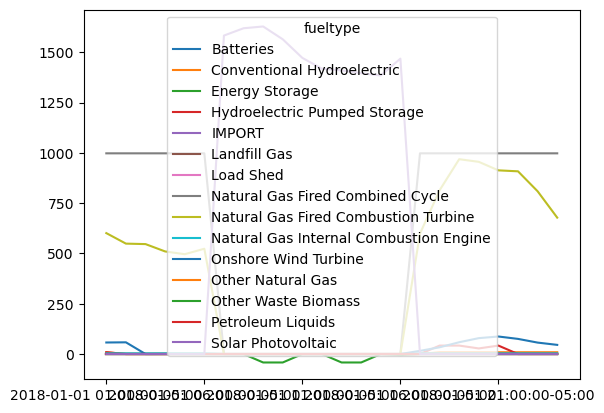

In [169]:
gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum().T.plot()

In [171]:
grouped = gen.drop(columns=['gen_id', 'bus']).groupby(['fueltype']).sum()
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000
Conventional Hydroelectric,8.900000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,8.9000,8.9000,8.900000,8.9000,8.9000,8.9000,8.900
Energy Storage,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,-42.0000,-42.0000,...,0.0000,-5.195876,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000
Hydroelectric Pumped Storage,9.129653,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,42.0000,42.0000,27.830347,42.0000,0.0000,0.0000,0.000
IMPORT,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000
Landfill Gas,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000
Load Shed,0.000000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,0.0000,0.0000,0.0000,0.000000,0.0000,0.0000,0.0000,0.000
Natural Gas Fired Combined Cycle,998.000000,998.0000,998.000,998.0000,998.0000,998.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,998.0000,998.0000,998.0000,998.000000,998.0000,998.0000,998.0000,998.000
Natural Gas Fired Combustion Turbine,601.274247,549.0049,546.656,510.1198,496.3646,523.5261,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.000000,598.7458,814.2557,968.8436,955.668553,913.2994,908.5568,809.2756,678.242


In [174]:
prices = pd.read_csv(join(outputs_dir, 'prices.csv'))

In [176]:
prices

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
0,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
1,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
2,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
3,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
4,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
485,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
486,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472
487,15.158472,14.548737,14.548737,14.548737,14.51215,14.548737,0.0,0.0,0.0,0.0,...,0.0,0.0,14.548737,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472,15.158472


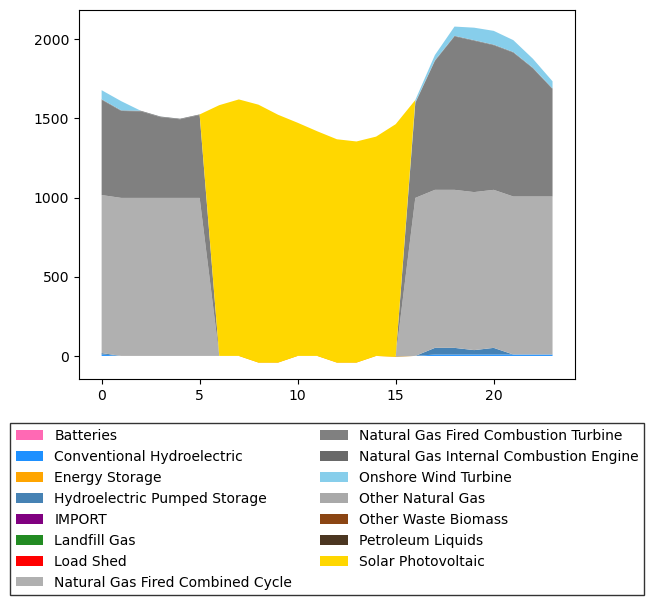

In [178]:
y = grouped.to_numpy()

fig, ax = plt.subplots()
plt.stackplot(range(len(y.T)), y, labels=grouped.index, colors=[i[1] for i in generator_colors]);
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1), ncol=2, fancybox=False, edgecolor='k')

In [180]:
generator_colors = [
    ("Solar Photovoltaic", "#FFD700"),
    ("Energy Storage", "orange"),
    ("Onshore Wind Turbine", "#87CEEB"),
    ("Conventional Hydroelectric", "#1E90FF"),
    ("Hydroelectric Pumped Storage", "#4682B4"),
    ("Natural Gas Fired Combined Cycle", "#B0B0B0"),
    ("Natural Gas Fired Combustion Turbine", "#808080"),
    ("Natural Gas Internal Combustion Engine", "#696969"),
    ("Other Natural Gas", "#A9A9A9"),
    ("Petroleum Liquids", "#4B3621"),
    ("Landfill Gas", "#228B22"),
    ("Other Waste Biomass", "#8B4513"),
    ("Batteries", "#FF69B4"),
    ("IMPORT", "#800080"),
    ("Load Shed", "#FF0000")
]
generator_colors.sort()

In [182]:
generator_colors

[('Batteries', '#FF69B4'),
 ('Conventional Hydroelectric', '#1E90FF'),
 ('Energy Storage', 'orange'),
 ('Hydroelectric Pumped Storage', '#4682B4'),
 ('IMPORT', '#800080'),
 ('Landfill Gas', '#228B22'),
 ('Load Shed', '#FF0000'),
 ('Natural Gas Fired Combined Cycle', '#B0B0B0'),
 ('Natural Gas Fired Combustion Turbine', '#808080'),
 ('Natural Gas Internal Combustion Engine', '#696969'),
 ('Onshore Wind Turbine', '#87CEEB'),
 ('Other Natural Gas', '#A9A9A9'),
 ('Other Waste Biomass', '#8B4513'),
 ('Petroleum Liquids', '#4B3621'),
 ('Solar Photovoltaic', '#FFD700')]

In [184]:
soc = pd.read_csv(join(outputs_dir, 'soc.csv'))

<Axes: >

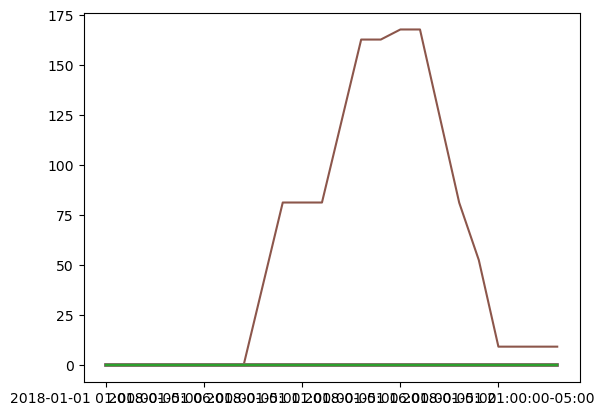

In [186]:
soc.T.iloc[0:-3,:].plot(legend=False)

<Axes: >

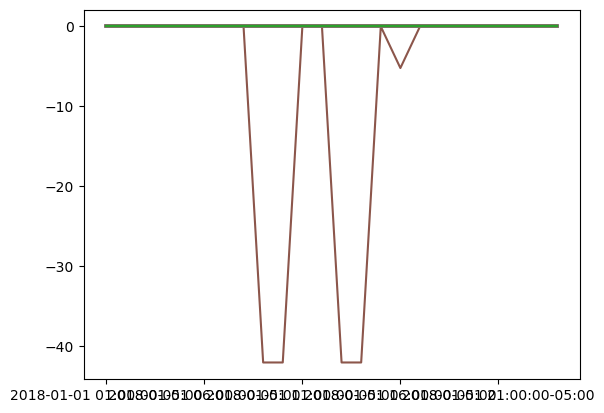

In [188]:
gen[gen['fueltype'] == "Energy Storage"].iloc[:,0:-3].T.plot(legend=False)

<Axes: >

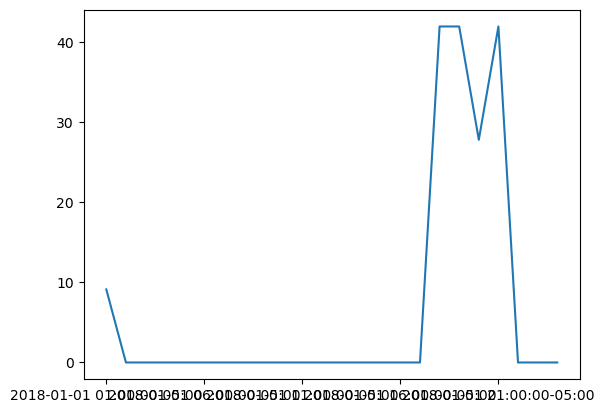

In [194]:
gen[gen['fueltype'] == "Hydroelectric Pumped Storage"].iloc[:,0:-3].T.plot(legend=False)

In [192]:
gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,5,IMPORT
1,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.4,1.4,1.4,1.4,1.4,1.4,1.4,2,7,Conventional Hydroelectric
2,60.5,60.5,60.5,60.5,60.5,60.5,0.0,0.0,0.0,0.0,...,60.5,60.5,60.5,60.5,60.5,60.5,60.5,3,12,Natural Gas Fired Combustion Turbine
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,13,Solar Photovoltaic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [121]:
battery_gen = gen[gen['gen_id'].isin(soc['gen_id'])]

In [123]:
battery_gen[(battery_gen.drop(columns=['bus']).set_index(['gen_id', 'fueltype']).sum(axis=1) != 0).values]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
38,10.629653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.0,0.0,0.0,42.0,42.0,0.0,36.96,39,100,Hydroelectric Pumped Storage
852,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,4,13,Energy Storage
853,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-1.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,13,43,Energy Storage
854,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-40.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,15,47,Energy Storage
856,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-1.5,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,22,60,Energy Storage
857,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-42.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,39,100,Energy Storage
858,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-2.5,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,43,104,Energy Storage
859,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-7.1,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,60,408,Energy Storage
861,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-2.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,71,457,Energy Storage
862,-0.000000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-2.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.00,78,471,Energy Storage


In [125]:
soc[(soc.iloc[:, 20] != 0)]

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
0,0.0,0.0,0.0,0.0,0.0,0.0,1.455,1.455,1.455,1.455,...,1.455000,1.455000,1.455000,1.455000,1.455000,1.455000,1.455,4,13,Batteries
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.970,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000,13,43,Batteries
2,0.0,0.0,0.0,0.0,0.0,0.0,38.800,38.800,38.800,38.800,...,38.800000,38.800000,38.800000,38.800000,38.800000,38.800000,38.800,15,47,Batteries
4,0.0,0.0,0.0,0.0,0.0,0.0,1.455,1.455,1.455,1.455,...,1.455000,1.455000,1.455000,1.455000,1.455000,1.455000,1.455,22,60,Batteries
5,0.0,0.0,0.0,0.0,0.0,0.0,40.740,40.740,40.740,40.740,...,124.701031,124.701031,124.701031,81.402062,38.103093,38.103093,0.000,39,100,Hydroelectric Pumped Storage
6,0.0,0.0,0.0,0.0,0.0,0.0,2.425,2.425,2.425,2.425,...,2.425000,2.425000,2.425000,2.425000,2.425000,2.425000,2.425,43,104,Batteries
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,6.887,6.887,...,6.887000,6.887000,6.887000,6.887000,6.887000,6.887000,6.887,60,408,Batteries
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,1.940,1.940,...,1.940000,1.940000,1.940000,1.940000,1.940000,1.940000,1.940,71,457,Batteries
10,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,1.940,1.940,...,1.940000,1.940000,1.940000,1.940000,1.940000,1.940000,1.940,78,471,Batteries
11,0.0,0.0,0.0,0.0,0.0,0.0,29.100,29.100,29.100,29.100,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000,80,485,Batteries


In [127]:
battery_gen

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00,gen_id,bus,fueltype
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,13,Batteries
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,43,Batteries
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,47,Batteries
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,54,Batteries
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,60,Batteries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,359,458,Energy Storage
1001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,360,87,Energy Storage
1002,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,361,68,Energy Storage
1003,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,362,91,Energy Storage


In [166]:
[gen[gen["fueltype"] == "Energy Storage"].iloc[:, i].min() for i in range(24)]

[-4842.0,
 -1745.0,
 -3218.2014853242113,
 -4842.0,
 -1745.0,
 -4842.0,
 -4388.377777732704,
 -1744.9999999999998,
 -3564.1313550225263,
 -2962.7983059650346,
 -1803.009014959942,
 -4842.0,
 -3526.241456615995,
 -4842.0,
 -1744.9999999999998,
 -4842.0,
 -1845.160104756907,
 -4842.0,
 -3187.7710143283525,
 -4842.0,
 -1744.9999999999998,
 -1745.0,
 -3804.297892846691,
 -1747.1445769736642]

In [168]:
grouped

,2018-01-01 01:00:00-05:00,2018-01-01 02:00:00-05:00,2018-01-01 03:00:00-05:00,2018-01-01 04:00:00-05:00,2018-01-01 05:00:00-05:00,2018-01-01 06:00:00-05:00,2018-01-01 07:00:00-05:00,2018-01-01 08:00:00-05:00,2018-01-01 09:00:00-05:00,2018-01-01 10:00:00-05:00,...,2018-01-01 15:00:00-05:00,2018-01-01 16:00:00-05:00,2018-01-01 17:00:00-05:00,2018-01-01 18:00:00-05:00,2018-01-01 19:00:00-05:00,2018-01-01 20:00:00-05:00,2018-01-01 21:00:00-05:00,2018-01-01 22:00:00-05:00,2018-01-01 23:00:00-05:00,2018-01-02 00:00:00-05:00
fueltype,,,,,,,,,,,,,,,,,,,,,
Batteries,10413.693345,5410.517192,9181.799120,10972.859078,5550.171396,11267.668095,10114.020549,5853.087042,9281.353829,9216.935690,...,5546.105644,11122.754030,6087.809312,10476.356648,9139.893747,10759.063609,6100.139873,6705.383140,8869.349134,6851.083548
Conventional Hydroelectric,46.108700,45.789100,45.510300,45.343600,45.279300,45.403900,45.673000,45.840400,45.687700,45.394500,...,44.759100,45.120800,45.823100,47.130400,47.957800,0.000000,47.833200,47.563300,47.021800,0.000000
Energy Storage,-17882.380099,-12366.514108,-15665.129773,-17928.225991,-13247.831640,-18287.256771,-18258.477829,-13573.481589,-17340.361127,-16436.790768,...,-12552.147595,-19757.100411,-13626.814760,-17642.528410,-16306.836080,-17490.333935,-13778.734512,-12754.128070,-16794.259005,-13773.585090
Hydroelectric Pumped Storage,0.000000,40.364727,105.963288,44.941569,0.000000,26.486489,0.000000,0.000000,0.000000,58.816315,...,62.844034,0.000000,0.000000,49.404241,0.000000,92.674350,76.565737,0.000000,77.062846,95.829266
IMPORT,403.630600,290.178967,327.883661,279.492669,490.564483,370.143377,981.061938,510.514934,412.316242,342.182788,...,302.136069,278.757469,1018.831811,316.408323,77.620300,77.592100,102.444300,83.335653,76.801100,76.227600
Landfill Gas,0.000000,152.128771,0.000000,182.511502,68.408495,217.395168,127.152669,106.654674,22.708517,75.272657,...,23.973191,0.000000,0.000000,118.410181,0.000000,5.305410,2.215289,106.692145,214.738602,0.000000
Load Shed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Natural Gas Fired Combined Cycle,163.713900,138.779189,134.516292,137.085588,158.825200,188.401500,134.562700,162.132600,161.232300,188.381600,...,78.858800,157.890800,202.097391,83.336500,111.841900,179.489000,111.576400,172.288900,131.446066,170.675500
Natural Gas Fired Combustion Turbine,294.254814,336.031820,360.335036,361.290014,291.673214,292.060914,324.291014,293.419814,368.134860,324.960740,...,253.865600,254.377600,508.995314,257.222000,633.119987,629.225220,545.950206,596.430042,582.462020,539.592706
